In [51]:
import torch
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import DataLoader, Dataset, random_split
from torchvision import models, transforms
from torchvision.datasets import ImageFolder
from torchvision import datasets, transforms
from tqdm import tqdm
import os
from PIL import Image
import glob
import xml.etree.ElementTree as ET

import matplotlib.pyplot as plt
import matplotlib.patches as patches
from torchvision.transforms.functional import to_pil_image

In [52]:
cats = glob.glob("/kaggle/input/dog-and-cat-detection/images/Cats*")
print(len(all), len(cats))

3686 3686


In [53]:
class CatsDataset(Dataset):
    def __init__(self, image_dir, annotation_dir, transform=None):
        self.image_dir = image_dir
        self.annotation_dir = annotation_dir
        self.transform = transform
        self.annotations = self._load_annotations()

    def _load_annotations(self):
        annotations = []
        for file in os.listdir(self.annotation_dir):
            if file.endswith(".xml"):
                tree = ET.parse(os.path.join(self.annotation_dir, file))
                root = tree.getroot()
                filename = root.find("filename").text
                bndbox = root.find("object").find("bndbox")
                bbox = [
                    int(bndbox.find("xmin").text),
                    int(bndbox.find("ymin").text),
                    int(bndbox.find("xmax").text),
                    int(bndbox.find("ymax").text),
                ]
                annotations.append((filename, bbox))
        return annotations

    def __len__(self):
        return len(self.annotations)
    
    def __getitem__(self, idx):
        filename, bbox = self.annotations[idx]
        img_path = os.path.join(self.image_dir, filename)
        image = Image.open(img_path).convert("RGB")
        original_width, original_height = image.size
        
        if self.transform:
            image = self.transform(image)
        
        bbox = self._resize_bbox(bbox, original_width, original_height, 224, 224)
        bbox = torch.tensor(bbox, dtype=torch.float32)
        
        return image, bbox

    def _resize_bbox(self, bbox, original_width, original_height, new_width, new_height):
        scale_x = new_width / original_width
        scale_y = new_height / original_height
        xmin, ymin, xmax, ymax = bbox
        return [
            xmin * scale_x,
            ymin * scale_y,
            xmax * scale_x,
            ymax * scale_y
        ]

transform = transforms.Compose([
    transforms.Resize((224, 224)),
    transforms.ToTensor(),
    transforms.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225])
])

image_dir = '/kaggle/input/dog-and-cat-detection/images'
annotation_dir = '/kaggle/input/dog-and-cat-detection/annotations'

dataset = CatsDataset(image_dir=image_dir, annotation_dir=annotation_dir, transform=transform)

train_size = int(0.8 * len(dataset))
test_size = len(dataset) - train_size
train_dataset, test_dataset = torch.utils.data.random_split(dataset, [train_size, test_size])

train_loader = DataLoader(train_dataset, batch_size=32, shuffle=True)
test_loader = DataLoader(test_dataset, batch_size=32, shuffle=False)

In [54]:
model = models.resnet18(pretrained=True)

In [55]:
num_features = model.fc.in_features
model.fc = nn.Linear(num_features, 4)

In [56]:
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
model.to(device)

ResNet(
  (conv1): Conv2d(3, 64, kernel_size=(7, 7), stride=(2, 2), padding=(3, 3), bias=False)
  (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (relu): ReLU(inplace=True)
  (maxpool): MaxPool2d(kernel_size=3, stride=2, padding=1, dilation=1, ceil_mode=False)
  (layer1): Sequential(
    (0): BasicBlock(
      (conv1): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (relu): ReLU(inplace=True)
      (conv2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn2): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    )
    (1): BasicBlock(
      (conv1): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (relu): ReLU(inplace=True)
  

In [57]:
criterion = nn.SmoothL1Loss()
optimizer = optim.Adam(model.parameters(), lr=0.001)

In [60]:
epochs = 20
model.train()
for epoch in range(epochs):
    running_loss = 0.0
    print(f"Epoch [{epoch + 1}/{epochs}]")
    
    for batch_idx, (images, bboxes) in enumerate(train_loader):
        images, bboxes = images.to(device), bboxes.to(device)
        outputs = model(images)
        loss = criterion(outputs, bboxes)

        optimizer.zero_grad()
        loss.backward()
        optimizer.step()

        running_loss += loss.item()

    # Epoch summary
    epoch_loss = running_loss / len(train_loader)
    print(f"  Epoch Loss: {epoch_loss:.4f}\n")


Epoch [1/20]
  Epoch Loss: 64.9316

Epoch [2/20]
  Epoch Loss: 25.2564

Epoch [3/20]
  Epoch Loss: 14.7400

Epoch [4/20]
  Epoch Loss: 11.1503

Epoch [5/20]
  Epoch Loss: 8.9901

Epoch [6/20]
  Epoch Loss: 7.6410

Epoch [7/20]
  Epoch Loss: 6.6905

Epoch [8/20]
  Epoch Loss: 6.3514

Epoch [9/20]
  Epoch Loss: 5.6683

Epoch [10/20]
  Epoch Loss: 5.4229

Epoch [11/20]
  Epoch Loss: 5.2926

Epoch [12/20]
  Epoch Loss: 5.0550

Epoch [13/20]
  Epoch Loss: 5.0148

Epoch [14/20]
  Epoch Loss: 4.6119

Epoch [15/20]
  Epoch Loss: 4.5074

Epoch [16/20]
  Epoch Loss: 4.2390

Epoch [17/20]
  Epoch Loss: 4.0555

Epoch [18/20]
  Epoch Loss: 3.9116

Epoch [19/20]
  Epoch Loss: 4.0277

Epoch [20/20]
  Epoch Loss: 3.7184



In [61]:
def denormalize(image_tensor, mean, std):
    mean = torch.tensor(mean).view(1, 3, 1, 1)
    std = torch.tensor(std).view(1, 3, 1, 1)
    return image_tensor * std + mean

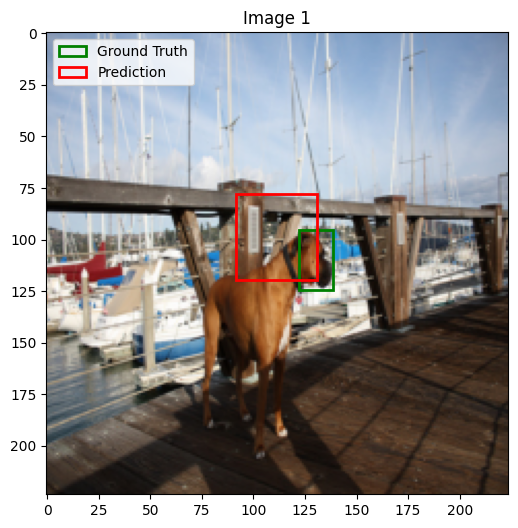

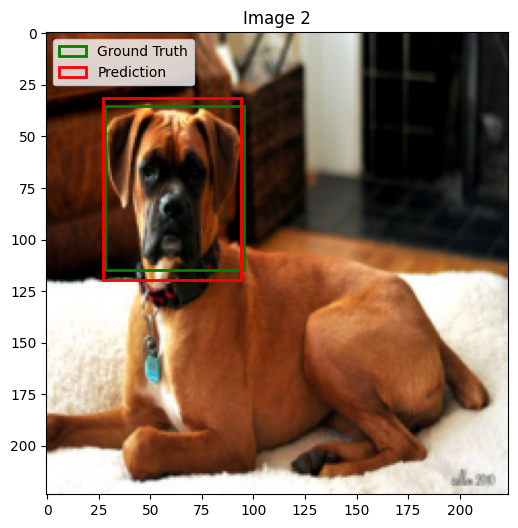

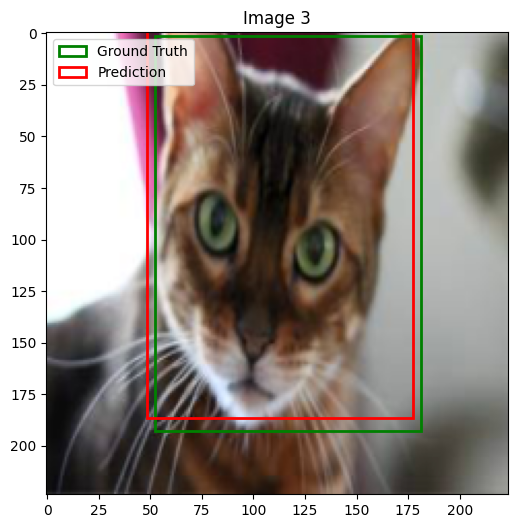

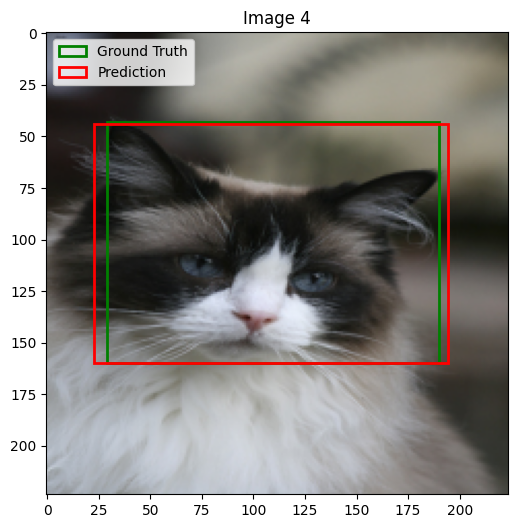

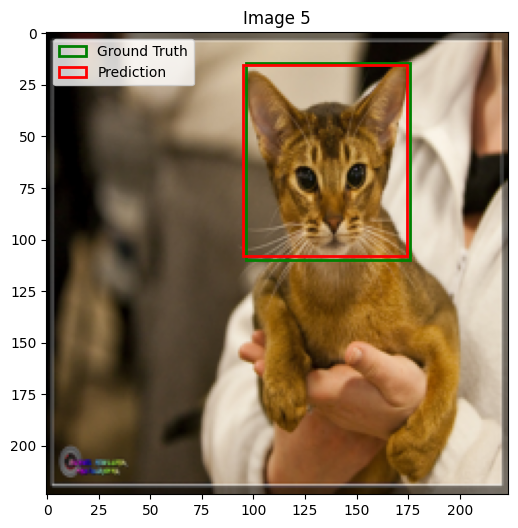

In [62]:
model.eval()
with torch.no_grad():
    for images, bboxes in test_loader:
        images, bboxes = images.to(device), bboxes.to(device)

        outputs = model(images)

        images = denormalize(images.cpu(), mean = [0.485, 0.456, 0.406], std = [0.229, 0.224, 0.225])
        bboxes = bboxes.cpu().numpy()
        outputs = outputs.cpu().numpy()

        for idx in range(min(5, len(images))):
            image = to_pil_image(images[idx])
            gt_box = bboxes[idx]  # [xmin, ymin, xmax, ymax]
            pred_box = outputs[idx]  # [xmin, ymin, xmax, ymax]

            fig, ax = plt.subplots(1, figsize=(6, 6))
            ax.imshow(image)

            rect_gt = patches.Rectangle(
                (gt_box[0], gt_box[1]),
                gt_box[2] - gt_box[0],
                gt_box[3] - gt_box[1],
                linewidth=2,
                edgecolor='green',
                facecolor='none',
                label='Ground Truth'
            )
            ax.add_patch(rect_gt)

            rect_pred = patches.Rectangle(
                (pred_box[0], pred_box[1]),
                pred_box[2] - pred_box[0],
                pred_box[3] - pred_box[1],
                linewidth=2,
                edgecolor='red',
                facecolor='none',
                label='Prediction'
            )
            ax.add_patch(rect_pred)
            ax.legend(loc='upper left')

            plt.title(f"Image {idx + 1}")
            plt.show()

        break